# Generative Adversarial Network with the MNIST dataset

Our goal in this project is to create an image generator of the mnist digits dataset. We are going to try using the 2 most popular library: tensorflow and 
pytorch.


## Using tensorflow

Here at first we have to get the data. In the case of mnist the data is prepared already in _tf.keras.datasets_. After we have to normalize the data to make
sure all the values from the images are clamped between 0 and 1, we need to do that because the algorithms we are going to use are quite sensible to large
magnitude. 

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [2]:
print(x_train[1].shape)

(28, 28)


Here we are normalizing the data so that the data is in an acceptable range since most model we work with are sensitive to data that have high range. We
might as well reshape the data using the numpy _reshape()_ function since most tensorflow convolutionl layer expect the image to be in the format 
(batch_size, width, height, channel), knowing that they are grey scaled images the channel is equal to 1.

In [ ]:
def normalize(x, y):
    x_normal = x.astype("float32") / 255.0
    y_normal = y.astype("float32") / 255.0
    x_normal = np.reshape(x_normal, (-1, 28, 28, 1))
    return x_normal, y_normal

x_train, y_train = normalize(x_train, y_train)
x_test, y_test = normalize(x_test, y_test)

In [6]:
x_train.shape

(60000, 28, 28, 1)

## Using a Convolution Variational Autoencoder

Now we can start by building the encoder which starts with an input layer that expect the image, pass it through a couple of convolutional layers of 
increasing number of filters, and we finish by getting the mean and the log variance of the codings distribution by passing the coding Dense layer's output
through another set of Dense layer with __coding\_size__ number of neurons. We finally get the coding by creating a custom sampling layer that samples 
a coding given the mean and the log variance of the inputs distribution.

In [24]:
# Building an encoder
codings_size = 10
inputs = tf.keras.layers.Input(shape=(28, 28, 1))
z = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
z = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(z)
z = tf.keras.layers.Flatten()(z)
z = tf.keras.layers.Dense(16, activation="relu")(z)
z_mean = tf.keras.layers.Dense(codings_size, name="z_mean")(z)
z_log_var = tf.keras.layers.Dense(codings_size, name="z_log_var")(z)

In [25]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.random.normal(shape=(tf.shape(mean)[0], codings_size))
        return mean + tf.exp(0.5 * log_var) * epsilon

In [26]:
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(inputs=inputs, outputs=[z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3136)      │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │     50,192 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 10)        │        170 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 10)        │        170 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_4          │ (None, 10)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,348 (270.89 KB)

 Trainable params: 69,348 (270.89 KB)

 Non-trainable params: 0 (0.00 B)

Here we are buiding the decoder. This model is in charge of the deconvolution process to get the original inputs. In order to do so we are passing our
latent representations through firstly a Dense layer which has a number of neurons equal to the number of filters outputed by the encoder's last 
convolutional layer. After getting the result we pass it through `Conv2DTranspose()` layers (simply mirroring the convolutional layers) which ultimately 
gives us the original image.

In [ ]:
# Building the decoder
decoder_inputs = tf.keras.layers.Input(shape=(codings_size,))
x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = tf.keras.layers.Reshape((7, 7, 64))(x)
x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = tf.keras.Model(decoder_inputs, [decoder_outputs], name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3136)           │        34,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,177 (352.25 KB)

 Trainable params: 90,177 (352.25 KB)

 Non-trainable params: 0 (0.00 B)

Here is the final model which combines the encoder and the decoder. This model is not quite sequential, so we need to use the Keras subclassing API to build a custom model. In the `call` method, we reconstruct an image given the coding (which we get by passing an input image through the encoder) and return it. The `train_step` method is special because we have to track two loss functions:

### The Latent Loss

The latent loss, also known as the KL divergence loss, has the objective of pushing the coding to look as if it was sampled from a Gaussian distribution. This is crucial for the Variational Autoencoder (VAE) to ensure that the latent space is continuous and allows for smooth interpolation between points. We use the KL divergence for this purpose, which is defined as:
$${\mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum_{i=1}^n \left[ 1 + \log(\sigma_i^2) - \sigma_i^2 - \mu_i^2 \right]}$$
Where:
- \( ${\mu _i}$ \) is the mean of the latent variable.
- \( ${\sigma _i}$ \) is the standard deviation of the latent variable.

This loss term ensures that the distribution of the latent variables is close to a standard normal distribution.

### The Reconstruction Loss

The reconstruction loss measures how much the reconstructed output differs from the original input. This loss function is similar to the loss functions used in other models and is crucial for ensuring that the VAE can accurately reconstruct the input data from the latent space. We can use Mean Squared Error (MSE) for this purpose, which is defined as:
$${\mathcal{L}_{\text{reconstruction}} = \frac{1}{n} \sum_{i=1}^n (x_i - \hat{x}_i)^2}$$
Where:
- \( ${x_i}$ \) is the original input.
- \( ${\hat{x}_i}$ \) is the reconstructed output.

The total loss for the VAE is the sum of the latent loss and the reconstruction loss:
$${\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{reconstruction}} + \mathcal{L}_{\text{KL}}}$$

By minimizing this total loss, the VAE learns to generate realistic data that is similar to the input data while ensuring that the latent space is well-structured.

In [28]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        _, _, codings = self.encoder(inputs)
        reconstructions = self.decoder(codings)
        return reconstructions
    
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            mean, log_var, codings = self.encoder(data)
            reconstructions = self.decoder(codings)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstructions), axis=(1, 2)))
            kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))

            total_loss = reconstruction_loss + kl_loss

        gradients = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        return {
            "reconstruction_loss": reconstruction_loss,
            "latent_loss": kl_loss,
            "loss": total_loss
        }

We now compile and train the model.

In [29]:
vae = VAE(encoder, decoder)

vae.compile(optimizer="adam", loss=lambda x, y: x + y)

vae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test))

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 108s 199ms/step - latent_loss: 6.8420e-04 - loss: 22.9535 - reconstruction_loss: 22.9528 - val_loss: 0.0011
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 105s 223ms/step - latent_loss: 6.8252e-04 - loss: 3.2829 - reconstruction_loss: 3.2822 - val_loss: 0.0010
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 138ms/step - latent_loss: 4.0624e-04 - loss: 3.1814 - reconstruction_loss: 3.1810 - val_loss: 0.0010
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 57s 121ms/step - latent_loss: 1.9933e-04 - loss: 3.1544 - reconstruction_loss: 3.1542 - val_loss: 0.0010
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 58s 123ms/step - latent_loss: 8.6430e-05 - loss: 3.1407 - reconstruction_loss: 3.1406 - val_loss: 0.0010
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - latent_loss: 3.4425e-05 - loss: 3.1332 - reconstruction_loss: 3.1331 - val_loss: 0.0010
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 116s 247ms/step - latent_loss: 1.2051e-05 - loss: 3.1281 - reconstruction_loss: 3.1281

tf.Tensor(
[-1.1088243  -0.51911634 -2.0678751  -0.61403066  0.08597574  0.25914395
  0.8538876  -0.32598132  2.1984422  -1.4284885 ], shape=(10,), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


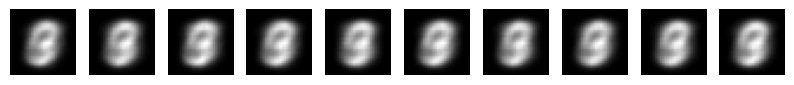

In [30]:
def plot_reconstructions(decoder, codings_size, num_images=10):
    samples = tf.random.normal((num_images, codings_size))
    print(samples[0])
    reconstructions = decoder.predict(samples)
    plt.figure(figsize=(10, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(reconstructions[i].reshape(28, 28), cmap="grey")
        plt.axis("off")

    plt.show()

plot_reconstructions(decoder, codings_size, 10)

## Using a Deep Convolutional Generative Adverserial Network

After a variational encoder, we are going for a GAN. A GAN is a model that is composed of a __generator__ and a discriminator. During training these part
have different purposes: the generator try to create data that is as resembling of the inputs as possible and the discriminator try to tell if the newly 
generated data is part of the input set or not. As time goes the generator becomes more and more capable of generating realistic data and the discriminator
is not able to tell apart the fake and the real data anymore reaching an equilibrium. 

### Normalizing and preparing the data for our algorithm

Regularly our model expects that the inputs be in a certain format. In the case of images(returned by the `tf.keras.datasets.mnist`), they are in the form
of 2D numpy arrays where the elements are the RGB values of the image.  We normalize this values to range between 0 and 1 after that we reshape those images
to make the 4D vectors(of shape [batch_size, width, height, channels]) since convolutional layers expect a channel dimension that isn't provided by the
dataset(since the images are greyscaled(meaning their channel is just 1)). We can ommit the batch_size dimension because we are not really using it.

In [31]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Conv2DTranspose, Conv2D, BatchNormalization, LeakyReLU, Reshape, Dropout, Flatten
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()


def normalize_data(x, y):
    x_normal = x.astype("float32") / 255.0
    y_normal = y.astype("float32") / 255.0
    x_normal.reshape(-1, 28, 28, 1)
    return x_normal, y_normal

X_train, y_train = normalize_data(X_train, y_train)
X_test, y_test = normalize_data(X_test, y_test)

After normalization, we can construct a dataset object with the images. This object was created by tensorflow to automatically handle batching, shuffling 
and prefetching(preparing the next batch while the current batch is running) during the training phase.

In [32]:
buffer_size = 60_000
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(1)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test)

In [33]:
type(train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

### Creating the generator

The generator is quite similar to an autoencoder's decoder. It is in charge of upsampling the input image and negate the noise by passing the image through
a Dense layer and several Conv2DTranspose layers of decreasing number of filters. 

In [34]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(Dense(7 * 7 * 256, activation="relu", use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))
    
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
    model.summary()
    return model

We can generate images already without training and look at the result.

c:\Users\bn489\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


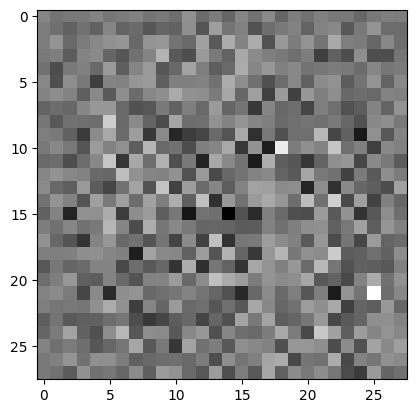

In [35]:
generator = build_generator()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")

### Creating the discriminator

The discriminator is a binary classifier. Our problem involves images so we replace dense layers with convolutional ones and we output whether or not the 
image is fake.

In [36]:
def build_decoder():
    decoder = tf.keras.Sequential()
    decoder.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)))
    decoder.add(LeakyReLU())
    decoder.add(Dropout(0.3))
    decoder.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    decoder.add(LeakyReLU())
    decoder.add(Dropout(0.3))
    decoder.add(Flatten())
    decoder.add(Dense(1))

    return decoder

In [37]:
loss= tf.keras.losses.BinaryCrossentropy(from_logits=True)

The loss function we are going to use is a binary cross entropy. In the discriminator's loss, we compare the real image to zeros and ones matrices which
produces the real and fake loss, their sum is the total loss of the discriminator. The generator's loss compares the generated images to an array of ones.

In [38]:
def discriminator_loss(y_true, y_pred):
    real_loss = loss(tf.ones_like(y_true), y_true)
    fake_loss = loss(tf.zeros_like(y_pred), y_pred)
    return real_loss + fake_loss

def generator_loss(y_pred):
    return loss(tf.ones_like(y_pred), y_pred)


discriminator = build_decoder()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

We can start building the final model. We build a custom training loop which take an input image. This function take the generator and generates a noisy
image with it. After that we give the generated image to the discriminator which compares it to the real image and output whether the image is fake or not.

In [52]:
import time

n_epochs = 20
noise_dim = 100
n_images = 10

tf.random.set_seed(42)
seed = tf.random.normal([n_images, noise_dim])


@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)
        y_true = discriminator(images, training=True)
        y_pred = discriminator(generated, training=True)

        gen_loss = generator_loss(y_pred)
        disc_loss = discriminator_loss(y_true, y_pred)

    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs=30):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        generate_and_save_images(generator, epoch + 1, seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [53]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

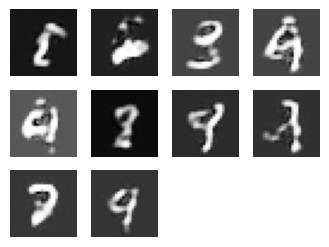

Time for epoch 1 is 1115.822613477707 sec


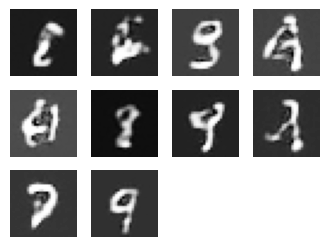

Time for epoch 2 is 765.9158325195312 sec


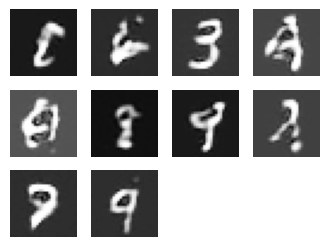

Time for epoch 3 is 590.3509068489075 sec


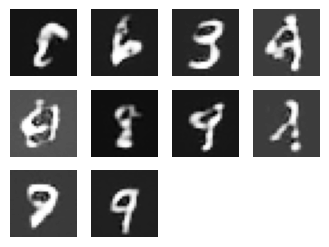

Time for epoch 4 is 534.2050223350525 sec


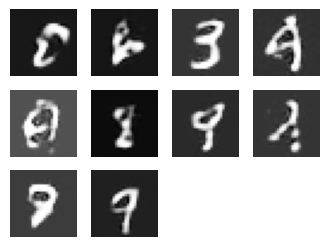

Time for epoch 5 is 534.3055558204651 sec


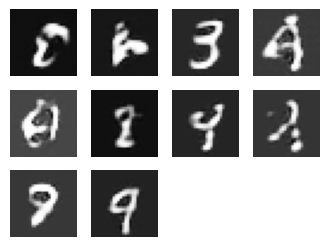

Time for epoch 6 is 815.6673929691315 sec


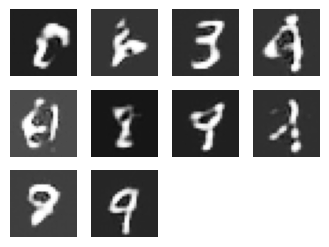

Time for epoch 7 is 583.5070986747742 sec


In [ ]:
train(train_dataset, n_epochs)

## Using a diffusion model

Diffusion models are a type of generative model used to create data, particularly images. The core idea behind diffusion models is to start with a noisy image and gradually denoise it to generate a realistic image. This process involves two main steps: the forward process and the reverse process.

In [1]:

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, ReLU, BatchNormalization

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

def normalize(x):
    x_normal = x.astype("float32") / 255.0
    x_normal = np.expand_dims(x_normal, axis=-1)
    return x_normal

x_train =  normalize(x_train)

Here we are going to use the diffusion model to generate images of the mnist dataset. We start by getting the data and normalizing it. After that we can
start by implementing the __forward process__ of the model. 

### Forward process

This process is quite simple, it generates random gaussian noise and applies it to the input image. This noisy image is then passed through the model that 
will try to reverse the process. We are adding noise to the image over several time steps _t_, we are using the following equation:
$${x_t = \sqrt{\alpha _t} . x_0 + \sqrt{1 + \alpha _t} . \epsilon}$$
Where:
- ${x_t}$ is the resulting noise at the timestep _t_.
- ${\alpha _t}$ is the cumulative product of the noise at timestep _t_
- ${\epsilon}$ is the randomly generated gaussian noise.

In [3]:
def forward_process(x, t, beta):
    alpha_t = np.prod(1 - beta[:t+1])
    noise = np.random.normal(0, 1, x.shape)
    return np.sqrt(alpha_t) * x + np.sqrt(1 - alpha_t) * noise

After that we are defining the model itself. A diffusion model is usually implemented using the U-Net architecture defined in the paper 
__"U-Net: Convolutional Networks for Biomedical Image Segmentation"__. The U-Net architecture is a model that is composed of an encoder and a decoder. The 
encoder is in charge of extracting the features of the image and the decoder is in charge of reconstructing the image. The U-Net architecture is quite 
popular in the image processing field because it is able to capture the global and local features of the image. It denoise the image by passing through a 
couple of convolutional layers before upsampling it back to the original size.

In [4]:
def unet(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 3, activation="relu", padding="same")(inputs)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 3, activation="relu", padding="same")(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(256, 3, activation="relu", padding="same")(x)

    x = Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = UpSampling2D(2)(x)
    x = Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = UpSampling2D(2)(x)

    outputs = Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    return tf.keras.Model(inputs, outputs)

The beta schedule is a schedule that is used to control the amount of noise that is added to the image. The idea is to start with a small amount of noise
and increase it as time goes. In the following code we are doing so by creating a schedule that is linearly increasing the noise.

In [5]:
def generate_beta_schedule(num_steps):
    beta_start = 1e-4
    beta_end = 0.02
    return np.linspace(beta_start, beta_end, num_steps, dtype=np.float32)

The next function defined our training loop. It the dataset and the model as input and train the model using the dataset. The training loop is quite simple
we start by getting the noise level using the beta schedule. After that we get the image and add noise to it. We then pass the noisy image through the model
and get the output. We then calculate the loss by comparing the output to the original image. We then calculate the gradients and update the model's weights accordinly.

In [6]:
def train(model, x_train, beta, n_steps, epochs, batch_size):
    optimizer = tf.keras.optimizers.Adam(1e-4)
    mse = tf.keras.losses.MeanSquaredError()

    for epoch in range(epochs):
        for step in range(0, len(x_train), batch_size):
            batch = x_train[step:step+ batch_size]
            t = np.random.randint(0, n_steps, size=batch_size)

            with tf.GradientTape() as tape:
                noised_images = [forward_process(batch[i], t[i], beta) for i in range(batch_size)]
                noised_images = np.array(noised_images)
                predicted_noise = model(noised_images, training=True)

                loss = mse(noised_images - batch, predicted_noise)

            gradients = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy()}")

The next function generates using the model, a beta value, the number of time steps we want and the shape of the final image. We start by generating a random sample from a normal distribution. We then pass this sample through the model and get the output. We then iterate over the number of time steps and pass the output through the model to get the final image.

In [7]:
def generate_images(model, beta, n_steps, shape):
    x = np.random.normal(0, 1, shape)
    print(x)
    for t in reversed(range(n_steps)):
        alpha_t = np.prod(1 - beta[:t+1])
        noise = model.predict(x)
        x = (x - np.sqrt(1 - alpha_t) * noise) / np.sqrt(alpha_t)
    return x

In [ ]:
n_steps = 100
batch_size = 32
beta = generate_beta_schedule(n_steps)
input_shape = x_train.shape[1:]

model = unet(input_shape)

train(model, x_train, beta, n_steps, 30, batch_size)

generated = generate_images(model, beta, n_steps, shape=(10, 28, 28, 1))


def print_images(images):
    plt.figure(figsize=(10, 1))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i].squeeze(), cmap="grey")
        plt.axis("off")

    plt.show()

print_images(generated)

## Using pytorch

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

n_steps = 100  # Number of diffusion steps
beta_start = 0.0001
beta_end = 0.02
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

betas = torch.linspace(beta_start, beta_end, n_steps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
posterior_variance = betas * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod)

# U-Net based diffusion model
class DiffusionModel(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64):
        super().__init__()
        
        self.time_mlp = nn.Sequential(
            nn.Linear(1, hidden_channels),
            nn.SiLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1)
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1, stride=2)
        
        self.conv4 = nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1)
        self.conv5 = nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1)
        
        self.conv6 = nn.ConvTranspose2d(hidden_channels, hidden_channels, 4, stride=2, padding=1)
        self.conv7 = nn.Conv2d(hidden_channels + hidden_channels, hidden_channels, 3, padding=1)
        self.final = nn.Conv2d(hidden_channels, input_channels, 3, padding=1)
        
    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.time_mlp(t)
        
        x1 = F.silu(self.conv1(x))
        x2 = F.silu(self.conv2(x1))
        x3 = F.silu(self.conv3(x2))
        
        x4 = F.silu(self.conv4(x3))
        x4 = x4 + t.unsqueeze(-1).unsqueeze(-1)  # Add time embedding
        x5 = F.silu(self.conv5(x4))
        
        x6 = self.conv6(x5)
        x6 = torch.cat([x6, x2], dim=1)  # Skip connection
        x7 = F.silu(self.conv7(x6))
        
        return self.final(x7)

def get_noisy_image(x_start, t):
    """Add noise to an image according to diffusion schedule"""
    noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].to(device)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
    
    return (
        sqrt_alphas_cumprod_t.view(-1, 1, 1, 1) * x_start +
        sqrt_one_minus_alphas_cumprod_t.view(-1, 1, 1, 1) * noise,
        noise
    )

def train_diffusion(model, dataloader, n_epochs=100, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        print(f"epoch {epoch}/{n_epochs}")
        total_loss = 0
        for batch, _ in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            t = torch.randint(0, n_steps, (batch.shape[0],), device=device)
            
            noisy_batch, noise = get_noisy_image(batch, t)
            
            predicted_noise = model(noisy_batch, t.float() / n_steps)
            
            loss = F.mse_loss(predicted_noise, noise)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        print(f"Epoch {epoch+1}, Average Loss: {total_loss/len(dataloader):.6f}")

@torch.no_grad()
def sample_images(model, n_samples=16, size=28):
    """Generate images using the trained diffusion model"""
    model.eval()
    
    x = torch.randn(n_samples, 1, size, size).to(device)
    
    for t in reversed(range(n_steps)):
        t_batch = torch.tensor([t] * n_samples).to(device)
        predicted_noise = model(x, t_batch.float() / n_steps)
        
        alpha = alphas[t].to(device)
        alpha_cumprod = alphas_cumprod[t].to(device)
        beta = betas[t].to(device)
        
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
            
        x = (1 / torch.sqrt(alpha)) * (
            x - ((1 - alpha) / (torch.sqrt(1 - alpha_cumprod))) * predicted_noise
        ) + torch.sqrt(beta) * noise
        
    model.train()
    return x

def main():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    
    model = DiffusionModel().to(device)
    
    train_diffusion(model, dataloader)
    
    samples = sample_images(model)

    return samples

samples = main()

def print_images(images):
    plt.figure(figsize=(10, 1))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i].squeeze(), cmap="grey")
        plt.axis("off")

    plt.show()

print_images(samples)


epoch 0/100
Epoch 1, Average Loss: 0.393983
epoch 1/100
Epoch 2, Average Loss: 0.259851
epoch 2/100
Epoch 3, Average Loss: 0.219560
epoch 3/100
Epoch 4, Average Loss: 0.195450
epoch 4/100


KeyboardInterrupt: 

__Side Note__:
- Try to implement _experience replay_,  _mini-batch discrimination_, _conditional gan_ and _style\_gan_.